In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # some plotting!
import seaborn as sns # so pretty!
from scipy import stats # I might use this
from sklearn.ensemble import RandomForestClassifier # checking if this is available
# from sklearn import cross_validation
%matplotlib inline

from subprocess import check_output

In [2]:
# import the training data set and make sure it's in correctly...
train = pd.read_csv('train_house.csv')
train_original = pd.read_csv('train_house.csv')
test = pd.read_csv('test_house.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3]:
# define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    elif len([i for i in df[col].T.notnull() if i == True])!=datalength: # if there's missing data..
        print('feature',col,'is missing data.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
        df1[col] = [counts.index.tolist().index(i) for i in df1[col]] # do the conversion
        return df1 # make the new (integer) column from the conversion
# and test the function...
fcntest = getObjectFeature(train,'LotShape')
fcntest.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,0,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


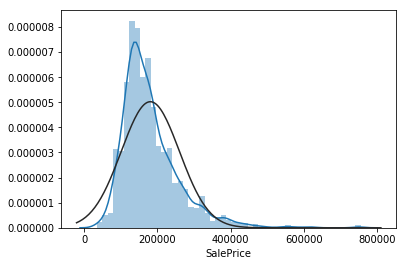

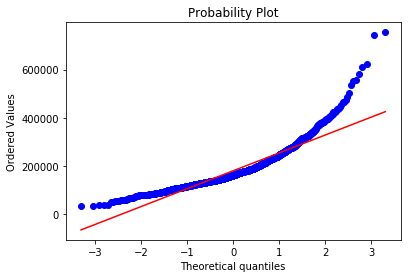

In [4]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [5]:
from sklearn.tree import DecisionTreeRegressor as dtr
# define the training data X...
X = train[['MoSold','YrSold','LotArea','BedroomAbvGr']]
Y = train[['SalePrice']]
# and the data for the competition submission...
X_test = test[['MoSold','YrSold','LotArea','BedroomAbvGr']]
print(X.head())
print(Y.head())

   MoSold  YrSold  LotArea  BedroomAbvGr
0       2    2008     8450             3
1       5    2007     9600             3
2       9    2008    11250             3
3       2    2006     9550             3
4      12    2008    14260             4
   SalePrice
0     208500
1     181500
2     223500
3     140000
4     250000


In [6]:
# let's set up some cross-validation analysis to evaluate our model and later models...
from sklearn.model_selection import cross_val_score
# try fitting a decision tree regression model...
DTR_1 = dtr(max_depth=None) # declare the regression model form. Let the depth be default.
# DTR_1.fit(X,Y) # fit the training data
scores_dtr = cross_val_score(DTR_1, X, Y, cv=10,scoring='explained_variance') # 10-fold cross validation
print('scores for k=10 fold validation:',scores_dtr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

scores for k=10 fold validation: [-1.20752846 -0.38706513 -0.44795158 -0.64239447 -0.29653956 -0.36114944
 -0.79046245 -0.74492697 -0.99609108 -0.29108701]
Est. explained variance: -0.62 (+/- 0.60)


In [7]:
from sklearn.ensemble import RandomForestRegressor as rfr
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']] # quick pre-processing of the target
np.random.seed(11111)
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: -0.26 (+/- 0.39)

estimators: 5
Est. explained variance: -0.01 (+/- 0.17)

estimators: 10
Est. explained variance: 0.07 (+/- 0.25)

estimators: 15
Est. explained variance: 0.10 (+/- 0.21)

estimators: 20
Est. explained variance: 0.10 (+/- 0.21)

estimators: 25
Est. explained variance: 0.10 (+/- 0.21)

estimators: 30
Est. explained variance: 0.12 (+/- 0.17)

estimators: 35
Est. explained variance: 0.13 (+/- 0.17)

estimators: 40
Est. explained variance: 0.14 (+/- 0.21)

estimators: 45
Est. explained variance: 0.14 (+/- 0.17)

estimators: 50
Est. explained variance: 0.13 (+/- 0.19)

estimators: 55
Est. explained variance: 0.13 (+/- 0.19)

estimators: 60
Est. explained variance: 0.13 (+/- 0.17)

estimators: 65
Est. explained variance: 0.14 (+/- 0.18)

estimators: 70
Est. explained variance: 0.15 (+/- 0.18)

estimators: 75
Est. explained variance: 0.14 (+/- 0.16)

estimators: 80
Est. explained variance: 0.15 (+/- 0.18)



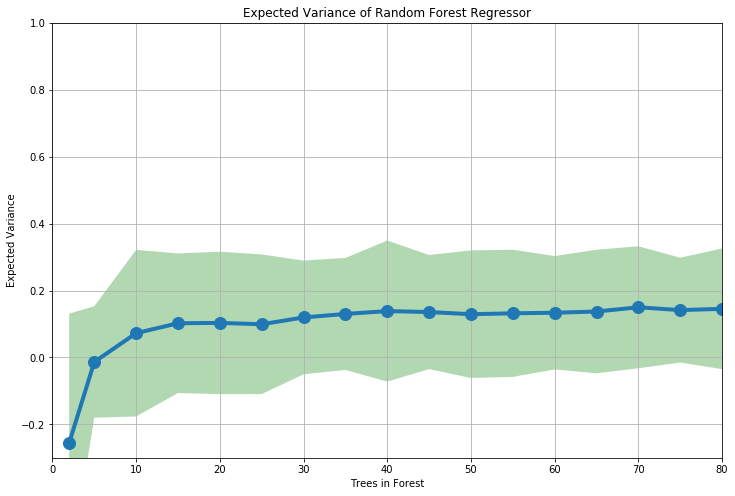

In [8]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

In [9]:
# list all the features we want. This is still arbitrary...
included_features = ['MoSold','YrSold','LotArea','BedroomAbvGr', # original data
                    'FullBath','HalfBath','TotRmsAbvGrd', # bathrooms and total rooms
                    'YearBuilt','YearRemodAdd', # age of the house
                    'LotShape','Utilities'] # some categoricals 
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# and the data for the competition submission...
X_test = test[included_features]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
X.head()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,MoSold,YrSold,LotArea,BedroomAbvGr,FullBath,HalfBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,LotShape,Utilities
0,2,2008,8450,3,2,1,8,2003,2003,0,0
1,5,2007,9600,3,2,0,6,1976,1976,0,0
2,9,2008,11250,3,2,1,6,2001,2002,1,0
3,2,2006,9550,3,1,0,7,1915,1970,1,0
4,12,2008,14260,4,2,1,9,2000,2000,1,0


In [10]:
# define the number of estimators to consider
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
# for each number of estimators, fit the model and find the results for 8-fold cross validation
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print("")
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: 0.57 (+/- 0.17)

estimators: 5
Est. explained variance: 0.64 (+/- 0.22)

estimators: 10
Est. explained variance: 0.63 (+/- 0.22)

estimators: 15
Est. explained variance: 0.68 (+/- 0.16)

estimators: 20
Est. explained variance: 0.68 (+/- 0.17)

estimators: 25
Est. explained variance: 0.67 (+/- 0.21)

estimators: 30
Est. explained variance: 0.68 (+/- 0.16)

estimators: 35
Est. explained variance: 0.68 (+/- 0.21)

estimators: 40
Est. explained variance: 0.68 (+/- 0.22)

estimators: 45
Est. explained variance: 0.68 (+/- 0.20)

estimators: 50
Est. explained variance: 0.69 (+/- 0.20)

estimators: 55
Est. explained variance: 0.67 (+/- 0.22)

estimators: 60
Est. explained variance: 0.69 (+/- 0.19)

estimators: 65
Est. explained variance: 0.69 (+/- 0.19)

estimators: 70
Est. explained variance: 0.68 (+/- 0.18)

estimators: 75
Est. explained variance: 0.69 (+/- 0.19)

estimators: 80
Est. explained variance: 0.68 (+/- 0.22)



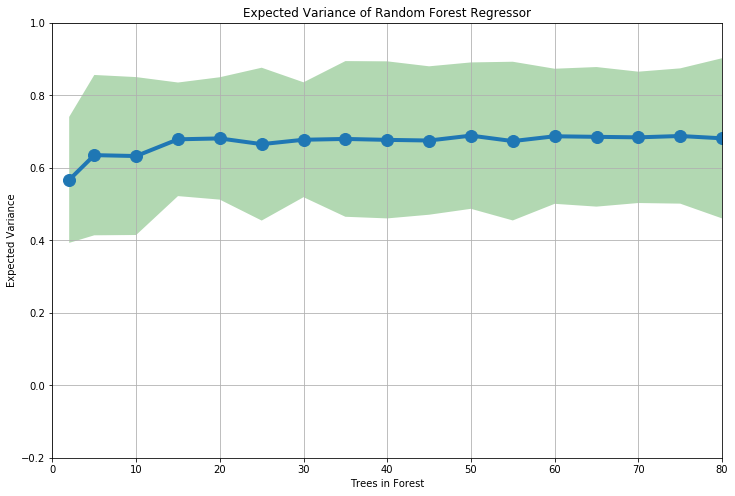

In [11]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([-.2,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()


In [13]:
mir_result = fs.mutual_info_regression(X, yt) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(len(included_features)):
    feature_scores.append([included_features[i],mir_result[i]])
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


[['YearBuilt' '0.2677757798551572']
 ['FullBath' '0.2522703120949492']
 ['YearRemodAdd' '0.20727848312654906']
 ['TotRmsAbvGrd' '0.17708770815933228']
 ['LotArea' '0.09227102630667483']
 ['HalfBath' '0.08804396870002185']
 ['LotShape' '0.07897712991834993']
 ['BedroomAbvGr' '0.0650963006714611']
 ['YrSold' '0.008602500962484605']
 ['MoSold' '0.0']
 ['Utilities' '0.0']]


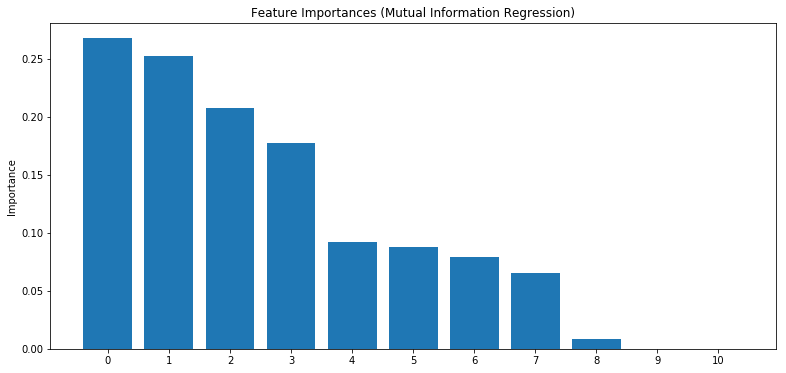

In [14]:
# and plot...
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
# plt.xlabel('Trees in Forest')
# plt.grid()
plt.show()

In [15]:
# define a function to do the necessary model building....
def getModel(sorted_scores,train,numFeatures):
    included_features = np.array(sorted_scores)[:,0][:numFeatures] # ordered list of important features
    # define the training data X...
    X = train[included_features]
    Y = train[['SalePrice']]
    # transform categorical data if included in X...
    for col in list(X):
        if X[col].dtype=='object':
            X = getObjectFeature(X, col)
    # define the number of estimators to consider
    estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
    mean_rfrs = []
    std_rfrs_upper = []
    std_rfrs_lower = []
    yt = [i for i in Y['SalePrice']]
    np.random.seed(11111)
    # for each number of estimators, fit the model and find the results for 8-fold cross validation
    for i in estimators:
        model = rfr(n_estimators=i,max_depth=None)
        scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
        mean_rfrs.append(scores_rfr.mean())
        std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
        std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting
    return mean_rfrs,std_rfrs_upper,std_rfrs_lower

# define a function to plot the model expected variance results...
def plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,numFeatures):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(estimators,mean_rfrs,marker='o',
           linewidth=4,markersize=12)
    ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                    facecolor='green',alpha=0.3,interpolate=True)
    ax.set_ylim([-.2,1])
    ax.set_xlim([0,80])
    plt.title('Expected Variance of Random Forest Regressor: Top %d Features'%numFeatures)
    plt.ylabel('Expected Variance')
    plt.xlabel('Trees in Forest')
    plt.grid()
    plt.show()
    return

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


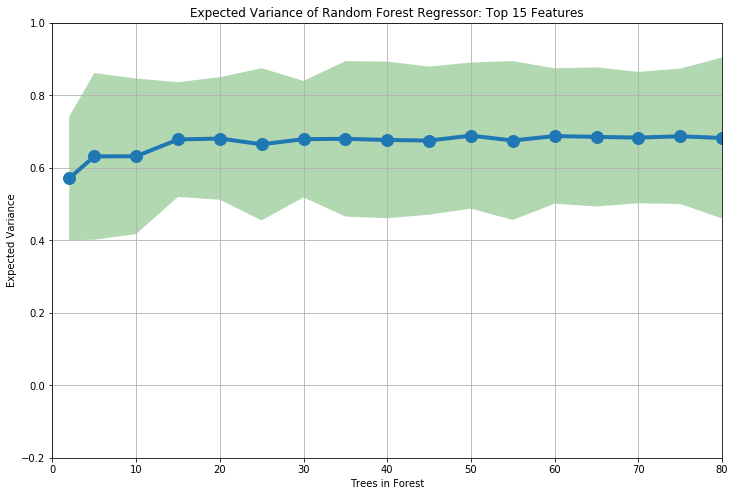

In [16]:
# top 15...
mean_rfrs,std_rfrs_upper,std_rfrs_lower = getModel(sorted_scores,train,15)
plotResults(mean_rfrs,std_rfrs_upper,std_rfrs_lower,15)

In [17]:
# build the model with the desired parameters...
numFeatures = 40 # the number of features to inlcude
trees = 60 # trees in the forest
included_features = np.array(sorted_scores)[:,0][:numFeatures]
# define the training data X...
X = train[included_features]
Y = train[['SalePrice']]
# transform categorical data if included in X...
for col in list(X):
    if X[col].dtype=='object':
        X = getObjectFeature(X, col)
yt = [i for i in Y['SalePrice']]
np.random.seed(11111)
model = rfr(n_estimators=trees,max_depth=None)
scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
print('explained variance scores for k=10 fold validation:',scores_rfr)
print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
# fit the model
model.fit(X,yt)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


explained variance scores for k=10 fold validation: [0.60558303 0.68865715 0.76256629 0.65012595 0.79556855 0.81189833
 0.69456011 0.73281597 0.48087297 0.63362591]
Est. explained variance: 0.69 (+/- 0.19)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
# re-define a function to convert an object (categorical) feature into an int feature
# 0 = most common category, highest int = least common.
def getObjectFeature(df, col, datalength=1460):
    if df[col].dtype!='object': # if it's not categorical..
        print('feature',col,'is not an object feature.')
        return df
    else:
        df1 = df
        counts = df1[col].value_counts() # get the counts for each label for the feature
#         print(col,'labels, common to rare:',counts.index.tolist()) # get an ordered list of the labels
        df1[col] = [counts.index.tolist().index(i) 
                    if i in counts.index.tolist() 
                    else 0 
                    for i in df1[col] ] # do the conversion
        return df1 # make the new (integer) column from the conversion

In [19]:
# apply the model to the test data and get the output...
X_test = test[included_features]
for col in list(X_test):
    if X_test[col].dtype=='object':
        X_test = getObjectFeature(X_test, col, datalength=1459)
# print(X_test.head(20))
y_output = model.predict(X_test.fillna(0)) # get the results and fill nan's with 0
print(y_output)

[132318.48333333 155155.         219090.         ... 190361.16666667
 125303.33333333 290033.9       ]


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# transform the data to be sure
y_output = np.exp(y_output)


In [22]:
# define the data frame for the results
saleprice = pd.DataFrame(y_output, columns=['SalePrice'])
# print(saleprice.head())
# saleprice.tail()
results = pd.concat([test['Id'],saleprice['SalePrice']],axis=1)
